<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 26 18:37:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.9 ; cuda:  cu111


In [ ]:
# install correct version of pytorch
# pytorch must be compatible with GPU, Detectron2 and not crash colab

# work with GPU A100-SXM4-40GB & Tesla V100-SXM2-16GB
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 torchtext==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.2 MB/s eta 0:16:45tcmalloc: large alloc 1147494400 bytes == 0x3911c000 @  0x7f8d486b6615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:13:41tcmalloc: large alloc 1434370048 bytes == 0x7d772000 @  0x7f8d486b6615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
     |████████████████████████████████| 6.9 MB 178 kB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 130 kB 102.3 MB/s 
     |████████████████████████████████| 151 kB 59.5 MB/s 
     |████████████████████████████████| 843 kB 41.4 MB/s 
     |████████████████████████████████| 596 kB 94.5 MB/s 
     |████████████████████████████████| 117 kB 80.5 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=0f541621fde1aed55dfe2ce5f7b2aa4b952d0338c50c3b90af658e0814867211
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.

In [ ]:
!pip install --upgrade mxnet-cu101 gluoncv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 12 kB/s 
     |████████████████████████████████| 1.3 MB 64.8 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
# Some basic setup:

# import some common libraries
import os, json, cv2, random, re, math
import numpy as np
import pandas as pd
from sklearn.metrics import auc
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow
from scipy.io import savemat

# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

from gluoncv.utils import download, viz
import gluoncv as gcv

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.9.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [ ]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

fs = 20

# !wget https://github.com/angusforbes/tagriver/raw/master/data/fonts/Century.TTF
# fm.fontManager.ttflist += fm.createFontList(['Century.TTF'])
# mpl.rc('font', family='Century', size=18)

!wget https://github.com/trishume/OpenTuringCompiler/raw/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
fm.fontManager.ttflist += fm.createFontList(['Times New Roman.ttf'])
mpl.rc('font', family='Times New Roman', size=fs)

# !wget https://github.com/CartoDB/cartodb/raw/master/app/assets/fonts/helvetica.ttf
# fm.fontManager.ttflist += fm.createFontList(['helvetica.ttf'])
# mpl.rc('font', family='helvetica', size=fs)

--2022-07-19 16:46:24--  https://github.com/trishume/OpenTuringCompiler/raw/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/trishume/OpenTuringCompiler/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf [following]
--2022-07-19 16:46:24--  https://raw.githubusercontent.com/trishume/OpenTuringCompiler/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf.2’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.02s   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  if sys.path[0] == '':


# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use the RGB fluorescence images of CAF model sample slides under 20X obj which only have one class: CAF.
We'll train a CAF detection model from an existing model pre-trained on COCO/Pascal VOC dataset, available in [detectron2's model zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

Note that COCO dataset does not have the "CAF" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [ ]:
from google.colab import files, drive   

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
print(os.listdir('/content/gdrive/My Drive/'))
# files.download("data/training_and_test_accuracies.png")

Mounted at /content/gdrive
['Colab Notebooks', 'Dataset', 'Shared_with_me', 'GitHub_AI4Embryo', 'Shared_files', 'FPM-A experiment', 'Images']


In [ ]:
root_path = '/content/gdrive/My Drive/Dataset/VOC_ModelSmp_CAF_only_by_slide_MATLAB_CAF_BB_anno_clean_v1'

VOC_path = os.path.join(root_path, 'VOC2018')
annot_path = os.path.join(VOC_path, 'Annotations')
split_path = os.path.join(VOC_path, 'ImageSets', 'Main')
image_path = os.path.join(VOC_path, 'JPEGImages')

dataset_text = {}
dataset_text["train"] = os.path.join(split_path, "train.txt")
dataset_text["val"] = os.path.join(split_path, "test.txt")

In [ ]:
npzfile = np.load(os.path.join(VOC_path, 'train_mean_std.npz'))
X_mean = npzfile['X_mean'].tolist()
X_std = npzfile['X_std'].tolist()
print('RGB')
print(X_mean)
print(X_std)

RGB
[8.878484982, 6.782542444, 33.381502166]
[16.88976592054826, 24.339260915030035, 44.59486385379693]


Register my CAF dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [ ]:
from detectron2.structures import BoxMode

def get_pol_dicts(dataset_txt, dataset_image_path):
  # Generate dataset_dict for train and val
  with open(dataset_txt) as f:
      content = f.readlines()
  content = [x.strip() for x in content] 
  imlist = []
  for img_name in content:
    imlist.append(img_name+'.jpg')

  dataset_dicts = []
  for img_id, v in enumerate(imlist):
      record = {}
      
      filename = os.path.join(dataset_image_path, v)
      height, width = cv2.imread(filename).shape[:2]
      
      record["file_name"] = filename
      record["image_id"] = img_id
      record["height"] = height
      record["width"] = width

      anno_name = annot_path+'/'+os.path.splitext(v)[0]+'.xml'
      objs = []
      # read in anno file
      tree = ET.parse(anno_name) 
      root = tree.getroot()
      # update the filename value in xml file according to its new name
      for obj in root.iter('object'):
        xmin = int(obj[4][0].text)
        ymin = int(obj[4][1].text)
        xmax = int(obj[4][2].text)
        ymax = int(obj[4][3].text)
        obj = {
            "bbox": [xmin, ymin, xmax, ymax],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": 0,
        }
        objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
for d in ["train", "val"]:
    DatasetCatalog.register("CAF_" + d, lambda d=d: get_pol_dicts(dataset_text[d], image_path))
    MetadataCatalog.get("CAF_" + d).set(thing_classes=["CAF"])

## Load trained models and generate prediction for testing dataset

We already fine-tuned 5 COCO-pretrained models on the CAF dataset.

https://detectron2.readthedocs.io/en/latest/modules/config.html

Now, let's run inference with the trained model on the testing dataset.

In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        arrangement: [xmin, ymin, xmax, ymax]
        The (xmin, ymin) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner
    bb2 : list
        arrangement: [xmin, ymin, xmax, ymax]
        The (xmin, ymin) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def remove_overlap(final_pred_bboxes, iou_thre):
  # Remove the overlapping predicted boxes coming later (with lower score) 
  # Input:
  #    final_pred_bboxes: list, predicted bounding boxes, with the format of [xmin, ymin, xmax, ymax]
  #    iou_thre: double, threshold to judge if overlapping
  # Output:
  #    final_pred_bboxes without overlapping boxes: list
  num_pred_bboxes = len(final_pred_bboxes)
  to_remove = []
  for k in range(num_pred_bboxes):
    base_bbox = final_pred_bboxes[k]
    for t in range(k+1,num_pred_bboxes):
      iou_test = get_iou(final_pred_bboxes[t], base_bbox)
      if iou_test>iou_thre:
        to_remove.append(t)
  remove_idx = np.unique(np.array(to_remove))
  for ele in sorted(remove_idx, reverse = True):
    del final_pred_bboxes[ele]
  return final_pred_bboxes
  
def remove_overlap_idx(final_pred_bboxes, iou_thre):
  # Remove the overlapping predicted boxes coming later (with lower score) 
  # Input:
  #    final_pred_bboxes: list, predicted bounding boxes, with the format of [xmin, ymin, xmax, ymax]
  #    iou_thre: double, threshold to judge if overlapping
  # Output:
  #    final_pred_bboxes without overlapping boxes: list
  num_pred_bboxes = len(final_pred_bboxes)
  to_remove = []
  for k in range(num_pred_bboxes):
    base_bbox = final_pred_bboxes[k]
    for t in range(k+1,num_pred_bboxes):
      iou_test = get_iou(final_pred_bboxes[t], base_bbox)
      if iou_test>iou_thre:
        to_remove.append(t)
  remove_idx = np.unique(np.array(to_remove))
  return remove_idx

def coco_instances_bbox_convert(coco_bbox):
  # coco_instances_results.json -> df_pred -> bbox: [xmin, ymin, x_size, y_size]
  # What to do: [xmin, ymin, x_size, y_size] -> [xmin, ymin, xmax, ymax]
  new_bbox = []
  new_bbox.append(coco_bbox[0])
  new_bbox.append(coco_bbox[1])
  new_bbox.append(coco_bbox[0]+coco_bbox[2])
  new_bbox.append(coco_bbox[1]+coco_bbox[3])
  return new_bbox

In [ ]:
val_dataset_dicts = get_pol_dicts(dataset_text["val"], image_path)
CAF_val_metadata = MetadataCatalog.get("CAF_val")

##### Load annotation result

In [ ]:
df_anno1 = pd.DataFrame.from_dict(val_dataset_dicts).explode('annotations').reset_index()
df_anno2 = pd.json_normalize(df_anno1['annotations'])
df_anno = pd.concat([df_anno1, df_anno2], axis=1).drop(columns=['index', 'height', 'width', 'annotations', 'bbox_mode'])
# Some images contain no CTCs, so the length of df_anno = 1929 > 1924.
# 1929 - 1924 = 5 images contain no CTCs.

print(df_anno)
df_anno.head()

                                             file_name  image_id  \
0    /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         0   
1    /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         1   
2    /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         1   
3    /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         2   
4    /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         2   
..                                                 ...       ...   
262  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        98   
263  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   
264  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   
265  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   
266  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   

                     bbox  category_id  
0                     NaN          NaN  
1    [487, 582, 586, 681]          0.0  
2       [1, 786, 45, 859]          0.0  
3     [52, 405, 178

,file_name,image_id,bbox,category_id
0,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,0,NaN,NaN
1,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,1,"[487, 582, 586, 681]",0.0
2,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,1,"[1, 786, 45, 859]",0.0
3,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,2,"[52, 405, 178, 522]",0.0
4,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,2,"[438, 743, 534, 839]",0.0


##### Load prediction result by retinanet_R_101_FPN_3x

In [ ]:
# Ensemble method 2
# 1. Aggregate all bounding boxes from five sub-models
# 2. Select with score_thre
# 3. Clean overlapping bounding boxes with clean_iou_thre
df_pred_all = [] # collect bounding boxes from 5 models
for k in range(5):
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")
  cfg.MODEL.PIXEL_MEAN = [X_mean[2], X_mean[1], X_mean[0]]
  cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]

  cfg.DATASETS.TRAIN = ("CTC_train",)
  cfg.DATASETS.TEST = ()
  cfg.DATALOADER.NUM_WORKERS = 2

  cfg.SOLVER.IMS_PER_BATCH = 2
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16 # 128 is faster, and good enough for this toy dataset (default: 512)
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # only has one class (CTC)
  cfg.MODEL.RETINANET.NUM_CLASSES = 1 # only has one class (CTC)

  cfg.SOLVER.BASE_LR = 0.00025 # pick a good LR
  cfg.SOLVER.MAX_ITER = 1000 # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset

  saving_path = "/content/gdrive/My Drive/Colab Notebooks/Research_project_CAF_detection/Detectron2_CAF_only_split_by_slide_MATLAB_CAF_BB/retinanet_R101_FPN_0.00025_trial"+str(k+1)
  cfg.OUTPUT_DIR = saving_path

  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
  cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.05 # set a custom testing threshold for this model, default = 0.05
  cfg.DATASETS.TEST = ("CTC_val",)

  # load prediction result excel
  json_file = os.path.join(saving_path, 'coco_instances_results.json')
  df_pred = pd.read_json(json_file) # df_pred is already sorted by 'image_id' and then 'score'
  df_pred['bbox'] = df_pred['bbox'].apply(coco_instances_bbox_convert)

  # save cleaned prediction results
  if k == 0:
    df_pred_all = df_pred
  else:
    df_pred_all = pd.concat([df_pred_all, df_pred])
df_pred_all = df_pred_all.sort_values(['image_id', 'category_id', 'score'], ascending=[True, True, False]).reset_index(drop=True)

score_thre = 0.91 # score threshold for child models
clean_iou_thre = 0.2 # IoU threshold for cleaning overlapping bounding boxes
iou_thre = 0.5 # IoU threshold for final evaluation

# select detections with score higher than threshold
df_pred_all_slt = df_pred_all[df_pred_all['score']>score_thre].reset_index(drop=True)

# clean detections by removing overlapping bounding boxes
pred_image_ids = np.unique(df_pred_all_slt['image_id'].to_numpy())
df_pred_all_clean = []
count = 0
for image_id in pred_image_ids:
  df_pred_image_id = df_pred_all_slt.loc[df_pred_all_slt.image_id==image_id].reset_index(drop=True)
  pred_bboxes = list(df_pred_image_id['bbox'])
  remove_idx = remove_overlap_idx(pred_bboxes, clean_iou_thre)
  df_pred_image_id_clean = df_pred_image_id.drop(remove_idx)
  if count == 0:
    df_pred_all_clean = df_pred_image_id_clean
  else:
    df_pred_all_clean = pd.concat([df_pred_all_clean, df_pred_image_id_clean], axis=0)
  count = count+1

# precision
numerator1 = 0
denominator1 = 0
# recall
numerator2 = 0
denominator2 = 0
test_image_ids = np.unique(df_anno['image_id'].to_numpy())
test_matrix_list = []
for image_id in test_image_ids:
  if image_id in np.unique(df_pred_all_clean['image_id'].to_numpy()): # at least one predicted box for this test image
    pred_bboxes = list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['bbox'])
    pred_scores = list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['score'])
    anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
    if np.sum(np.isnan(np.array(anno_bboxes))): # no annotated box for this test image
      denominator1 = denominator1+len(pred_scores)
    else: # at least one annotated box for this test image
      iou_matrix = np.zeros([len(pred_bboxes),len(anno_bboxes)])
      for pred_idx, pred_bbox in enumerate(pred_bboxes):
        for anno_idx, anno_bbox in enumerate(anno_bboxes):
          iou_matrix[pred_idx, anno_idx] = get_iou(pred_bbox, anno_bbox)
      success_matrix = []
      for k in range(iou_matrix.shape[0]): # scan through prediction boxes by row
        pred_row = iou_matrix[k,:] > iou_thre
        if np.sum(pred_row)>1: # make sure a prediction box will not be used twice
          pred_row = iou_matrix[k,:] == np.max(iou_matrix[k,:])
        if k==0:
          success_matrix = pred_row
        else:
          success_matrix = np.vstack((success_matrix,pred_row))
      success_matrix_clean = success_matrix.cumsum(axis=0).cumsum(axis=0) == 1
      if len(success_matrix_clean.shape)==1:
        success_matrix_clean = np.array([success_matrix_clean])
      test_matrix_list.append(success_matrix_clean)
  else: # no predicted box for this test image
    anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
    if not np.sum(np.isnan(np.array(anno_bboxes))): # at least one annotated box for this test image
      denominator2 = denominator2+len(anno_bboxes)

for success_matrix_clean in test_matrix_list:
  numerator1 = numerator1+np.sum(success_matrix_clean)
  numerator2 = numerator2+np.sum(success_matrix_clean)
  denominator1 = denominator1+success_matrix_clean.shape[0]
  denominator2 = denominator2+success_matrix_clean.shape[1]

precision = numerator1/denominator1
recall = numerator2/denominator2
print('Ensemble result')
print('Correct detection: %d; Missed detection: %d; Wrong detection: %d.' % (numerator1, denominator2-numerator2, denominator1-numerator1))
print('Precision = %.1f%%, Recall = %.1f%%' % (precision*100, recall*100))

In [ ]:
# Varying score_thre to get Precision-Recall curve
score_thre_list = np.linspace(0.0, 1.0, num=101, endpoint=True)
precision_list = []
recall_list = []
for score_thre in score_thre_list:
  # select detections with score higher than threshold
  df_pred_all_slt = df_pred_all[df_pred_all['score']>score_thre].reset_index(drop=True)

  if len(df_pred_all_slt) == 0:
    precision = 1
    recall = 0
    print('Score threshold = %.2f' % score_thre)
    print('Correct detection: %d; Missed detection: %d; Wrong detection: %d.' % (0, 1924, 0))
    print('Precision = %.1f%%, Recall = %.1f%%' % (precision*100, recall*100))
    precision_list.append(precision*100)
    recall_list.append(recall*100)
  else:
    # clean detections by removing overlapping bounding boxes
    pred_image_ids = np.unique(df_pred_all_slt['image_id'].to_numpy())
    df_pred_all_clean = []
    count = 0
    for image_id in pred_image_ids:
      df_pred_image_id = df_pred_all_slt.loc[df_pred_all_slt.image_id==image_id].reset_index(drop=True)
      pred_bboxes = list(df_pred_image_id['bbox'])
      remove_idx = remove_overlap_idx(pred_bboxes, clean_iou_thre)
      df_pred_image_id_clean = df_pred_image_id.drop(remove_idx)
      if count == 0:
        df_pred_all_clean = df_pred_image_id_clean
      else:
        df_pred_all_clean = pd.concat([df_pred_all_clean, df_pred_image_id_clean], axis=0)
      count = count+1

    # precision
    numerator1 = 0
    denominator1 = 0
    # recall
    numerator2 = 0
    denominator2 = 0
    test_image_ids = np.unique(df_anno['image_id'].to_numpy())
    test_matrix_list = []
    for image_id in test_image_ids:
      if image_id in np.unique(df_pred_all_clean['image_id'].to_numpy()): # at least one predicted box for this test image
        pred_bboxes = list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['bbox'])
        pred_scores = list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['score'])
        anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
        if np.sum(np.isnan(np.array(anno_bboxes))): # no annotated box for this test image
          denominator1 = denominator1+len(pred_scores)
        else: # at least one annotated box for this test image
          iou_matrix = np.zeros([len(pred_bboxes),len(anno_bboxes)])
          for pred_idx, pred_bbox in enumerate(pred_bboxes):
            for anno_idx, anno_bbox in enumerate(anno_bboxes):
              iou_matrix[pred_idx, anno_idx] = get_iou(pred_bbox, anno_bbox)
          success_matrix = []
          for k in range(iou_matrix.shape[0]): # scan through prediction boxes by row
            pred_row = iou_matrix[k,:] > iou_thre
            if np.sum(pred_row)>1: # make sure a prediction box will not be used twice
              pred_row = iou_matrix[k,:] == np.max(iou_matrix[k,:])
            if k==0:
              success_matrix = pred_row
            else:
              success_matrix = np.vstack((success_matrix,pred_row))
          success_matrix_clean = success_matrix.cumsum(axis=0).cumsum(axis=0) == 1
          if len(success_matrix_clean.shape)==1:
            success_matrix_clean = np.array([success_matrix_clean])
          test_matrix_list.append(success_matrix_clean)
      else: # no predicted box for this test image
        anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
        if not np.sum(np.isnan(np.array(anno_bboxes))): # at least one annotated box for this test image
          denominator2 = denominator2+len(anno_bboxes)

    for success_matrix_clean in test_matrix_list:
      numerator1 = numerator1+np.sum(success_matrix_clean)
      numerator2 = numerator2+np.sum(success_matrix_clean)
      denominator1 = denominator1+success_matrix_clean.shape[0]
      denominator2 = denominator2+success_matrix_clean.shape[1]
    
    if denominator1 == 0:
      precision = 1
      recall = numerator2/denominator2
    else:
      precision = numerator1/denominator1
      recall = numerator2/denominator2
    print('Score threshold = %.2f' % score_thre)
    print('Correct detection: %d; Missed detection: %d; Wrong detection: %d.' % (numerator1, denominator2-numerator2, denominator1-numerator1))
    print('Precision = %.1f%%, Recall = %.1f%%' % (precision*100, recall*100))
    precision_list.append(precision*100)
    recall_list.append(recall*100)

# calculate area under precision-recall curve
xx = np.flip(np.array(recall_list))
yy = np.flip(np.array(precision_list))
print('The AUC is {}'.format(auc(xx,yy)/10000))

Score threshold = 0.00
Correct detection: 245; Missed detection: 2; Wrong detection: 2100.
Precision = 10.4%, Recall = 99.2%
Score threshold = 0.01
Correct detection: 245; Missed detection: 2; Wrong detection: 2100.
Precision = 10.4%, Recall = 99.2%
Score threshold = 0.02
Correct detection: 245; Missed detection: 2; Wrong detection: 2100.
Precision = 10.4%, Recall = 99.2%
Score threshold = 0.03
Correct detection: 245; Missed detection: 2; Wrong detection: 2100.
Precision = 10.4%, Recall = 99.2%
Score threshold = 0.04
Correct detection: 245; Missed detection: 2; Wrong detection: 2100.
Precision = 10.4%, Recall = 99.2%
Score threshold = 0.05
Correct detection: 245; Missed detection: 2; Wrong detection: 2100.
Precision = 10.4%, Recall = 99.2%
Score threshold = 0.06
Correct detection: 245; Missed detection: 2; Wrong detection: 1888.
Precision = 11.5%, Recall = 99.2%
Score threshold = 0.07
Correct detection: 245; Missed detection: 2; Wrong detection: 1739.
Precision = 12.3%, Recall = 99.2%


In [ ]:
# save the precision-recall curve
out_file = "/content/gdrive/My Drive/Colab Notebooks/Research_project_CAF_detection/Detectron2_CAF_only_split_by_slide_MATLAB_CAF_BB/retinanet_R101_FPN_0.00025_ensemble_pr_curve.npz"
np.savez(out_file, recall=xx, precision=yy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


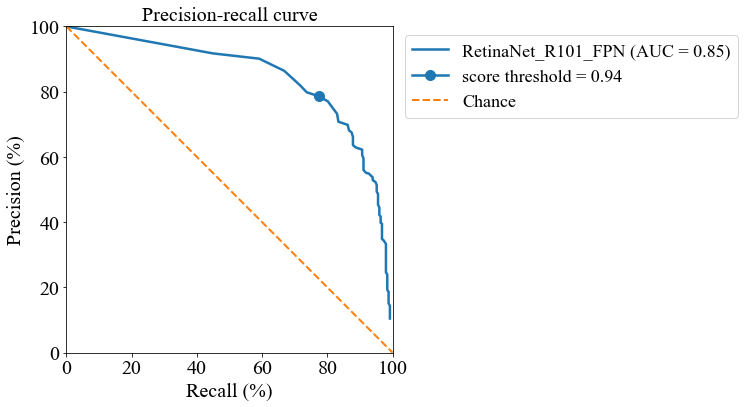

In [ ]:
# draw the precision-recall curve
model_list = ['retinanet_R101_FPN']
model_name_list = ['RetinaNet_R101_FPN']
# colors = plt.cm.magma(np.linspace(0.2,0.8,len(model_list)))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

x_list = []
y_list = []
AUC_list = []
for model in model_list:
  model_file = "/content/gdrive/My Drive/Colab Notebooks/Research_project_CAF_detection/Detectron2_CAF_only_split_by_slide_MATLAB_CAF_BB/"+model+'_0.00025_ensemble_pr_curve.npz'
  data = np.load(model_file)
  x_list.append(data['recall'])
  y_list.append(data['precision'])
  AUC_list.append(auc(data['recall'],data['precision'])/10000)

p_idx = 100-np.array([94])
score_thre_list = [0.94] 
xx = np.linspace(0, 100, num=101, endpoint=True)
# plot the precision-recall curve for ensemble model from different baselines
fig, ax = plt.subplots(figsize=(6, 6))
for k, model in enumerate(model_list):
  ax.plot(x_list[k], y_list[k], color=colors[k], linewidth=2.5, label=model_name_list[k]+' (AUC = %.2f' % AUC_list[k]+')')
  ax.plot(x_list[k][p_idx[k]], y_list[k][p_idx[k]], linewidth=2.5, marker='o', markersize=10, label='score threshold = %.2f' % score_thre_list[k])
ax.plot(xx, 100-xx, linewidth=2, linestyle='--', label='Chance')
ax.set_aspect('equal', adjustable='box')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Recall (%)', fontsize=fs)
ax.set_ylabel('Precision (%)', fontsize=fs)
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
ax.set_title('Precision-recall curve', fontsize=fs)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, fontsize=fs-2)

fig.tight_layout()
plt.show()

##### Load prediction result by faster_rcnn_R_101_FPN_3x

In [ ]:
# Ensemble method 2
# 1. Aggregate all bounding boxes from five sub-models
# 2. Select with score_thre
# 3. Clean overlapping bounding boxes with clean_iou_thre
df_pred_all = [] # collect bounding boxes from 5 models
for k in range(5):
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
  cfg.MODEL.PIXEL_MEAN = [X_mean[2], X_mean[1], X_mean[0]]
  cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]

  cfg.DATASETS.TRAIN = ("CAF_train",)
  cfg.DATASETS.TEST = ()
  cfg.DATALOADER.NUM_WORKERS = 2

  cfg.SOLVER.IMS_PER_BATCH = 2
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16 # 128 is faster, and good enough for this toy dataset (default: 512)
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # only has one class (CTC)

  cfg.SOLVER.BASE_LR = 0.00025 # pick a good LR
  cfg.SOLVER.MAX_ITER = 1000 # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset

  saving_path = "/content/gdrive/My Drive/Colab Notebooks/Research_project_CAF_detection/Detectron2_CAF_only_split_by_slide_MATLAB_CAF_BB/faster_rcnn_R101_FPN_0.00025_trial"+str(k+1)
  cfg.OUTPUT_DIR = saving_path

  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
  cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.05 # set a custom testing threshold for this model, default = 0.05
  cfg.DATASETS.TEST = ("CAF_val",)

  # load prediction result excel
  json_file = os.path.join(saving_path, 'coco_instances_results.json')
  df_pred = pd.read_json(json_file) # df_pred is already sorted by 'image_id' and then 'score'
  df_pred['bbox'] = df_pred['bbox'].apply(coco_instances_bbox_convert)

  # save cleaned prediction results
  if k == 0:
    df_pred_all = df_pred
  else:
    df_pred_all = pd.concat([df_pred_all, df_pred])
df_pred_all = df_pred_all.sort_values(['image_id', 'category_id', 'score'], ascending=[True, True, False]).reset_index(drop=True)

score_thre = 0.98 # score threshold for child models
clean_iou_thre = 0.2 # IoU threshold for cleaning overlapping bounding boxes
iou_thre = 0.5 # IoU threshold for final evaluation

# select detections with score higher than threshold
df_pred_all_slt = df_pred_all[df_pred_all['score']>score_thre].reset_index(drop=True)

# clean detections by removing overlapping bounding boxes
pred_image_ids = np.unique(df_pred_all_slt['image_id'].to_numpy())
df_pred_all_clean = []
count = 0
for image_id in pred_image_ids:
  df_pred_image_id = df_pred_all_slt.loc[df_pred_all_slt.image_id==image_id].reset_index(drop=True)
  pred_bboxes = list(df_pred_image_id['bbox'])
  remove_idx = remove_overlap_idx(pred_bboxes, clean_iou_thre)
  df_pred_image_id_clean = df_pred_image_id.drop(remove_idx)
  if count == 0:
    df_pred_all_clean = df_pred_image_id_clean
  else:
    df_pred_all_clean = pd.concat([df_pred_all_clean, df_pred_image_id_clean], axis=0)
  count = count+1

# precision
numerator1 = 0
denominator1 = 0
# recall
numerator2 = 0
denominator2 = 0
test_image_ids = np.unique(df_anno['image_id'].to_numpy())
test_matrix_list = []
for image_id in test_image_ids:
  if image_id in np.unique(df_pred_all_clean['image_id'].to_numpy()): # at least one predicted box for this test image
    pred_bboxes = list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['bbox'])
    pred_scores = list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['score'])
    anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
    if np.sum(np.isnan(np.array(anno_bboxes))): # no annotated box for this test image
      denominator1 = denominator1+len(pred_scores)
    else: # at least one annotated box for this test image
      iou_matrix = np.zeros([len(pred_bboxes),len(anno_bboxes)])
      for pred_idx, pred_bbox in enumerate(pred_bboxes):
        for anno_idx, anno_bbox in enumerate(anno_bboxes):
          iou_matrix[pred_idx, anno_idx] = get_iou(pred_bbox, anno_bbox)
      success_matrix = []
      for k in range(iou_matrix.shape[0]): # scan through prediction boxes by row
        pred_row = iou_matrix[k,:] > iou_thre
        if np.sum(pred_row)>1: # make sure a prediction box will not be used twice
          pred_row = iou_matrix[k,:] == np.max(iou_matrix[k,:])
        if k==0:
          success_matrix = pred_row
        else:
          success_matrix = np.vstack((success_matrix,pred_row))
      success_matrix_clean = success_matrix.cumsum(axis=0).cumsum(axis=0) == 1
      if len(success_matrix_clean.shape)==1:
        success_matrix_clean = np.array([success_matrix_clean])
      test_matrix_list.append(success_matrix_clean)
  else: # no predicted box for this test image
    anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
    if not np.sum(np.isnan(np.array(anno_bboxes))): # at least one annotated box for this test image
      denominator2 = denominator2+len(anno_bboxes)

for success_matrix_clean in test_matrix_list:
  numerator1 = numerator1+np.sum(success_matrix_clean)
  numerator2 = numerator2+np.sum(success_matrix_clean)
  denominator1 = denominator1+success_matrix_clean.shape[0]
  denominator2 = denominator2+success_matrix_clean.shape[1]

precision = numerator1/denominator1
recall = numerator2/denominator2
print('Ensemble result')
print('Correct detection: %d; Missed detection: %d; Wrong detection: %d.' % (numerator1, denominator2-numerator2, denominator1-numerator1))
print('Precision = %.1f%%, Recall = %.1f%%' % (precision*100, recall*100))

Ensemble result
Correct detection: 204; Missed detection: 43; Wrong detection: 23.
Precision = 89.9%, Recall = 82.6%


In [ ]:
# Varying score_thre to get Precision-Recall curve
score_thre_list = np.linspace(0.0, 1.0, num=101, endpoint=True)
precision_list = []
recall_list = []
for score_thre in score_thre_list:
  # select detections with score higher than threshold
  df_pred_all_slt = df_pred_all[df_pred_all['score']>score_thre].reset_index(drop=True)

  if len(df_pred_all_slt) == 0:
    precision = 1
    recall = 0
    print('Score threshold = %.2f' % score_thre)
    print('Correct detection: %d; Missed detection: %d; Wrong detection: %d.' % (0, 1924, 0))
    print('Precision = %.1f%%, Recall = %.1f%%' % (precision*100, recall*100))
    precision_list.append(precision*100)
    recall_list.append(recall*100)
  else:
    # clean detections by removing overlapping bounding boxes
    pred_image_ids = np.unique(df_pred_all_slt['image_id'].to_numpy())
    df_pred_all_clean = []
    count = 0
    for image_id in pred_image_ids:
      df_pred_image_id = df_pred_all_slt.loc[df_pred_all_slt.image_id==image_id].reset_index(drop=True)
      pred_bboxes = list(df_pred_image_id['bbox'])
      remove_idx = remove_overlap_idx(pred_bboxes, clean_iou_thre)
      df_pred_image_id_clean = df_pred_image_id.drop(remove_idx)
      if count == 0:
        df_pred_all_clean = df_pred_image_id_clean
      else:
        df_pred_all_clean = pd.concat([df_pred_all_clean, df_pred_image_id_clean], axis=0)
      count = count+1

    # precision
    numerator1 = 0
    denominator1 = 0
    # recall
    numerator2 = 0
    denominator2 = 0
    test_image_ids = np.unique(df_anno['image_id'].to_numpy())
    test_matrix_list = []
    for image_id in test_image_ids:
      if image_id in np.unique(df_pred_all_clean['image_id'].to_numpy()): # at least one predicted box for this test image
        pred_bboxes = list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['bbox'])
        pred_scores = list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['score'])
        anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
        if np.sum(np.isnan(np.array(anno_bboxes))): # no annotated box for this test image
          denominator1 = denominator1+len(pred_scores)
        else: # at least one annotated box for this test image
          iou_matrix = np.zeros([len(pred_bboxes),len(anno_bboxes)])
          for pred_idx, pred_bbox in enumerate(pred_bboxes):
            for anno_idx, anno_bbox in enumerate(anno_bboxes):
              iou_matrix[pred_idx, anno_idx] = get_iou(pred_bbox, anno_bbox)
          success_matrix = []
          for k in range(iou_matrix.shape[0]): # scan through prediction boxes by row
            pred_row = iou_matrix[k,:] > iou_thre
            if np.sum(pred_row)>1: # make sure a prediction box will not be used twice
              pred_row = iou_matrix[k,:] == np.max(iou_matrix[k,:])
            if k==0:
              success_matrix = pred_row
            else:
              success_matrix = np.vstack((success_matrix,pred_row))
          success_matrix_clean = success_matrix.cumsum(axis=0).cumsum(axis=0) == 1
          if len(success_matrix_clean.shape)==1:
            success_matrix_clean = np.array([success_matrix_clean])
          test_matrix_list.append(success_matrix_clean)
      else: # no predicted box for this test image
        anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
        if not np.sum(np.isnan(np.array(anno_bboxes))): # at least one annotated box for this test image
          denominator2 = denominator2+len(anno_bboxes)

    for success_matrix_clean in test_matrix_list:
      numerator1 = numerator1+np.sum(success_matrix_clean)
      numerator2 = numerator2+np.sum(success_matrix_clean)
      denominator1 = denominator1+success_matrix_clean.shape[0]
      denominator2 = denominator2+success_matrix_clean.shape[1]
    
    if denominator1 == 0:
      precision = 1
      recall = numerator2/denominator2
    else:
      precision = numerator1/denominator1
      recall = numerator2/denominator2
    print('Score threshold = %.2f' % score_thre)
    print('Correct detection: %d; Missed detection: %d; Wrong detection: %d.' % (numerator1, denominator2-numerator2, denominator1-numerator1))
    print('Precision = %.1f%%, Recall = %.1f%%' % (precision*100, recall*100))
    precision_list.append(precision*100)
    recall_list.append(recall*100)

# calculate area under precision-recall curve
xx = np.flip(np.array(recall_list))
yy = np.flip(np.array(precision_list))
print('The AUC is {}'.format(auc(xx,yy)/10000))

Score threshold = 0.00
Correct detection: 241; Missed detection: 6; Wrong detection: 1402.
Precision = 14.7%, Recall = 97.6%
Score threshold = 0.01
Correct detection: 241; Missed detection: 6; Wrong detection: 1402.
Precision = 14.7%, Recall = 97.6%
Score threshold = 0.02
Correct detection: 241; Missed detection: 6; Wrong detection: 1402.
Precision = 14.7%, Recall = 97.6%
Score threshold = 0.03
Correct detection: 241; Missed detection: 6; Wrong detection: 1402.
Precision = 14.7%, Recall = 97.6%
Score threshold = 0.04
Correct detection: 241; Missed detection: 6; Wrong detection: 1402.
Precision = 14.7%, Recall = 97.6%
Score threshold = 0.05
Correct detection: 241; Missed detection: 6; Wrong detection: 1402.
Precision = 14.7%, Recall = 97.6%
Score threshold = 0.06
Correct detection: 241; Missed detection: 6; Wrong detection: 1347.
Precision = 15.2%, Recall = 97.6%
Score threshold = 0.07
Correct detection: 241; Missed detection: 6; Wrong detection: 1292.
Precision = 15.7%, Recall = 97.6%


In [ ]:
# save the precision-recall curve
out_file = "/content/gdrive/My Drive/Colab Notebooks/Research_project_CAF_detection/Detectron2_CAF_only_split_by_slide_MATLAB_CAF_BB/faster_rcnn_R101_FPN_0.00025_ensemble_pr_curve.npz"
np.savez(out_file, recall=xx, precision=yy)

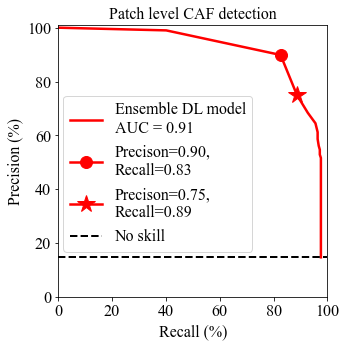

In [ ]:
# draw the precision-recall curve
prop_cycle = plt.rcParams['axes.prop_cycle']

model = 'faster_rcnn_R101_FPN'
model_file = "/content/gdrive/My Drive/Colab Notebooks/Research_project_CAF_detection/Detectron2_CAF_only_split_by_slide_MATLAB_CAF_BB/"+model+'_0.00025_ensemble_pr_curve.npz'
data = np.load(model_file)
recall = data['recall']
precision = data['precision']
AUC = auc(data['recall'],data['precision'])/10000

p_idx = 100-np.array([98,97])
score_thre_list = [0.98,0.97]
marker_list = ['o','*']
marker_size_list = [12,18]
xx = np.linspace(0, 100, num=101, endpoint=True)

# plot the precision-recall curve for ensemble model from different baselines
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(recall, precision, color='r', linewidth=2.5, label='Ensemble DL model\nAUC = %.2f' % AUC)
for t in range(len(score_thre_list)):
  ax.plot(recall[p_idx[t]], precision[p_idx[t]], 'r', linewidth=2.5, marker=marker_list[t], markersize=marker_size_list[t], label='Precison=%.2f,\nRecall=%.2f' % (precision[p_idx[t]]/100,recall[p_idx[t]]/100))
ax.plot(xx, precision[-1]*np.ones(xx.shape), linewidth=2, linestyle='--', label='No skill', color='k')
ax.set_aspect('equal', adjustable='box')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Recall (%)', fontsize=fs)
ax.set_ylabel('Precision (%)', fontsize=fs)
ax.set_xlim([0, 100])
ax.set_ylim([0, 101])
ax.set_title('Patch level CAF detection', fontsize=fs)
ax.legend(loc="upper center", bbox_to_anchor=(0.37,0.77), ncol=1, fontsize=fs)

# fig.tight_layout()
plt.show()

/content/gdrive/My Drive/Dataset/VOC_ModelSmp_CAF_only_by_slide_MATLAB_CAF_BB_anno_clean_v1/VOC2018/JPEGImages/Model_system-Slide2-Mixture-1225-2021_r1c1x5y5.jpg


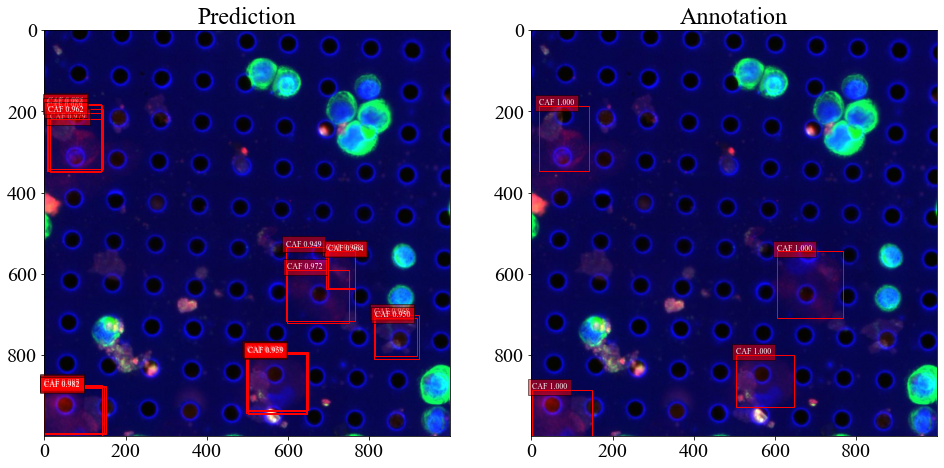

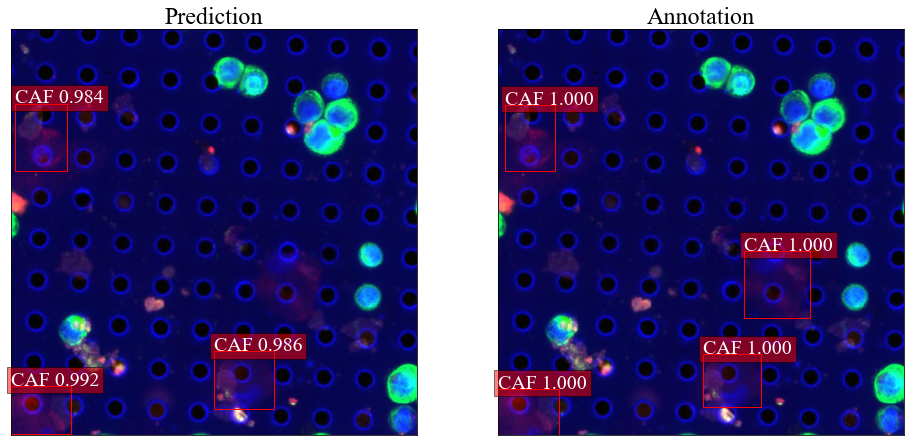

In [ ]:
# image_id = 85
image_id = 55
file_name = df_anno[df_anno['image_id']==image_id]['file_name'].tolist()[0]
print(file_name)
x, image = gcv.data.transforms.presets.ssd.load_test(file_name, 1000)

anno_bboxes = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['bbox']))
anno_cids = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['category_id']))
anno_scores = np.ones(anno_cids.shape)

pred_raw_bboxes = np.asarray(list(df_pred_all.loc[df_pred_all.image_id==image_id]['bbox']))
pred_raw_scores = np.asarray(list(df_pred_all.loc[df_pred_all.image_id==image_id]['score']))
pred_raw_cids = np.asarray(list(df_pred_all.loc[df_pred_all.image_id==image_id]['category_id']))

pred_clean_bboxes = np.asarray(list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['bbox']))
pred_clean_scores = np.asarray(list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['score']))
pred_clean_cids = np.asarray(list(df_pred_all_clean.loc[df_pred_all_clean.image_id==image_id]['category_id']))

# visualize the raw prediction and annotation side by side -> thresh = 0.05
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1 = viz.plot_bbox(image, pred_raw_bboxes, pred_raw_scores, pred_raw_cids, thresh=0.94, class_names=['CAF'], ax=ax1, linewidth=1, fontsize=8)
ax1.set_title('Prediction')
if np.sum(np.isnan(anno_bboxes)):
  ax2.imshow(image)
  ax2.set_title('Annotation')
else:
  ax2 = viz.plot_bbox(image, anno_bboxes, anno_scores, anno_cids, thresh=0.05, class_names=['CAF'], ax=ax2, linewidth=1, fontsize=8)
  ax2.set_title('Annotation')
plt.show()

# visualize the cleaned prediction and annotation side by side -> thresh = 0.4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1 = viz.plot_bbox(image, pred_clean_bboxes, pred_clean_scores, pred_clean_cids, thresh=0.4, class_names=['CAF'], ax=ax1, linewidth=1, fontsize=20)
ax1.set_title('Prediction')
ax1.set_xticks([])
ax1.set_yticks([])
if np.sum(np.isnan(anno_bboxes)):
  ax2.imshow(image)
  ax2.set_title('Annotation')
else:
  ax2 = viz.plot_bbox(image, anno_bboxes, anno_scores, anno_cids, thresh=0.4, class_names=['CAF'], ax=ax2, linewidth=1, fontsize=20)
  ax2.set_title('Annotation')
  ax2.set_xticks([])
  ax2.set_yticks([])
plt.show()

In [ ]:
from scipy.io import savemat
mdic = {"DL_pred": pred_clean_bboxes, "Human_anno": anno_bboxes}
savemat("/content/gdrive/My Drive/Colab Notebooks/Research_project_CAF_detection/"+os.path.splitext(os.path.basename(file_name))[0]+"_DL_scorethre97.mat", mdic)

##### Compare PR curve of different baseline models

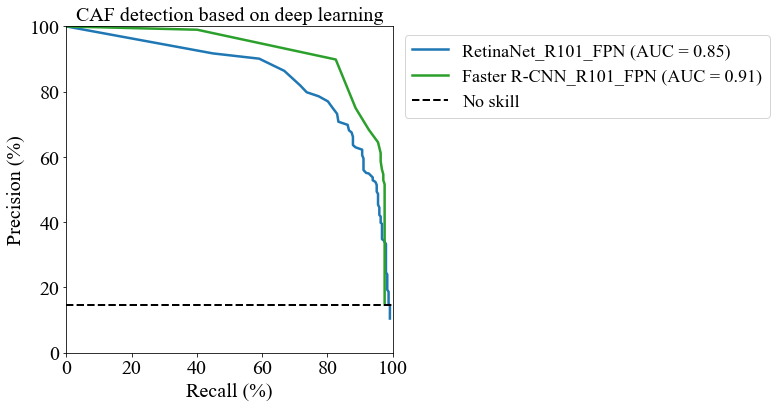

In [ ]:
model_list = ['retinanet_R101_FPN','faster_rcnn_R101_FPN']
model_name_list = ['RetinaNet_R101_FPN','Faster R-CNN_R101_FPN']
# colors = plt.cm.magma(np.linspace(0.2,0.8,len(model_list)))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors_list = prop_cycle.by_key()['color']
colors = [colors_list[0],colors_list[2]]

x_list = []
y_list = []
AUC_list = []
for model in model_list:
  model_file = "/content/gdrive/My Drive/Colab Notebooks/Research_project_CAF_detection/Detectron2_CAF_only_split_by_slide_MATLAB_CAF_BB/"+model+'_0.00025_ensemble_pr_curve.npz'
  data = np.load(model_file)
  x_list.append(data['recall'])
  y_list.append(data['precision'])
  AUC_list.append(auc(data['recall'],data['precision'])/10000)

p_idx = 100-np.array([94,98])
score_thre_list = [0.94,0.98] 
xx = np.linspace(0, 100, num=101, endpoint=True)
# plot the precision-recall curve for ensemble model from different baselines
fig, ax = plt.subplots(figsize=(6, 6))
for k, model in enumerate(model_list):
  ax.plot(x_list[k], y_list[k], color=colors[k], linewidth=2.5, label=model_name_list[k]+' (AUC = %.2f' % AUC_list[k]+')')
  # ax.plot(x_list[k][p_idx[k]], y_list[k][p_idx[k]], linewidth=2.5, marker='o', markersize=10, label='score threshold = %.2f' % score_thre_list[k])
ax.plot(xx, precision[-1]*np.ones(xx.shape), linewidth=2, linestyle='--', label='No skill', color='k')
ax.set_aspect('equal', adjustable='box')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Recall (%)', fontsize=fs)
ax.set_ylabel('Precision (%)', fontsize=fs)
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
ax.set_title('CAF detection based on deep learning', fontsize=fs)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, fontsize=fs-2)

# fig.tight_layout()
plt.show()